<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P6


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



2022-06-10 10:46:47.574268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-10 10:46:47.574300: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

GPU device not found


2022-06-10 10:46:50.984859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 10:46:50.993201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vincent/devel/vjuge/oc-iml/venv/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-10 10:46:50.993221: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-10 10:46:50.993261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rocketstation): /proc/driver/nvidia/version does not exist


## Download Dataset

In [4]:

def load_dataset(display_summary=False, as_supervised=True) -> tuple[tf.data.Dataset, tf.data.Dataset, tfds.core.DatasetInfo] :
    """Return Train, Test datasets and related informations
    :return: 
    ds_train (tf.data.DataSet) The requested training dataset.
    ds_test (tf.data.DataSet) The requested test dataset.
    ds_info (tfds.core.DatasetInfo) The requested dataset info.
    """
    # https://www.tensorflow.org/datasets/catalog/stanford_dogs
    (ds_test, ds_val, ds_train), ds_info = tfds.load('stanford_dogs', 
                                                split=["test", "train[0%:20%]", "train[20%:]"], 
                                                shuffle_files=True, 
                                                as_supervised=as_supervised,
                                                with_info=True)
    assert isinstance(ds_train, tf.data.Dataset)
    if (display_summary): print(ds_info)
    return ds_train, ds_test, ds_val, ds_info


ds_train, ds_test, ds_val, ds_info = load_dataset(display_summary=True, as_supervised=True)

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
           

Visualize Data

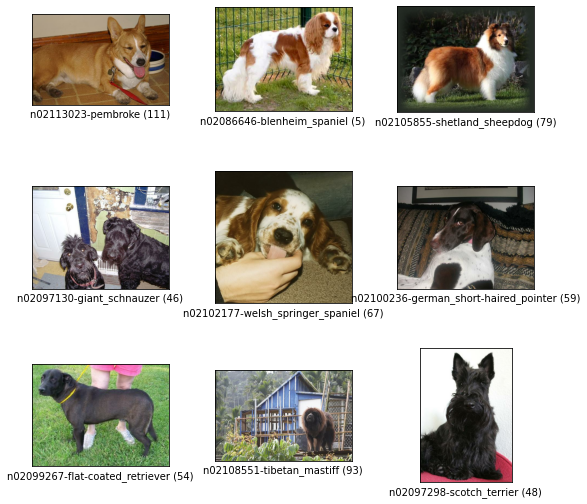

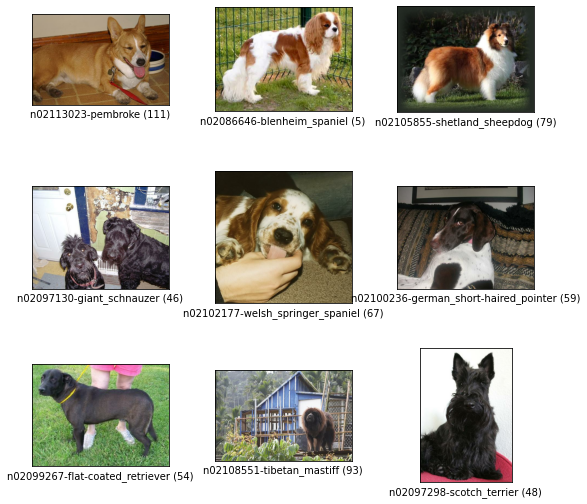

In [11]:
# show examples of samples from dataset
tfds.show_examples(ds_train, ds_info)

In [13]:
# show batches content, atthis stage dataset is not batched
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(333, 500, 3)
()


In [14]:
ds_info.features
ds_info.splits
ds_info.splits['train'].filenames

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

{'train': <SplitInfo num_examples=12000, num_shards=4>,
 'test': <SplitInfo num_examples=8580, num_shards=4>}

['stanford_dogs-train.tfrecord-00000-of-00004',
 'stanford_dogs-train.tfrecord-00001-of-00004',
 'stanford_dogs-train.tfrecord-00002-of-00004',
 'stanford_dogs-train.tfrecord-00003-of-00004']

Dataset has 120 classes

In [15]:
num_classes = ds_info.features['label'].num_classes
print(num_classes)

120


Dataset contains only 20k samples

In [16]:
ds_train.cardinality().numpy() + ds_val.cardinality().numpy() + ds_test.cardinality().numpy()

20580

Show a sample of image from dataset

tf.Tensor(111, shape=(), dtype=int64)


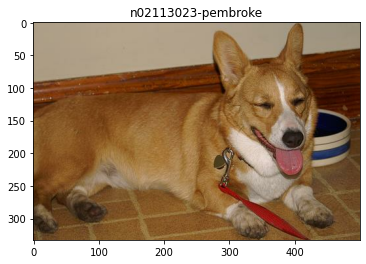

In [17]:
get_label_name = ds_info.features['label'].int2str

image, label = next(iter(ds_train))
print(label)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Preprocessing

Here we want to preprocess images: resizing, scaling, augment data, etc.


In [18]:
def compare_images(original, result, title=""):
    fig = plt.figure(figsize=(16,6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.subplot(1, 2, 2)
    plt.title("Processed Image")
    plt.suptitle(title, color="black", fontsize=22, y=.98)
    plt.imshow(result)
    plt.show()

### Resizing & Scaling

In [19]:
IMG_SIZE = 244

resize_and_rescale = tf.keras.Sequential([
        layers.Resizing(IMG_SIZE, IMG_SIZE),
        layers.Rescaling(1./255)
    ])

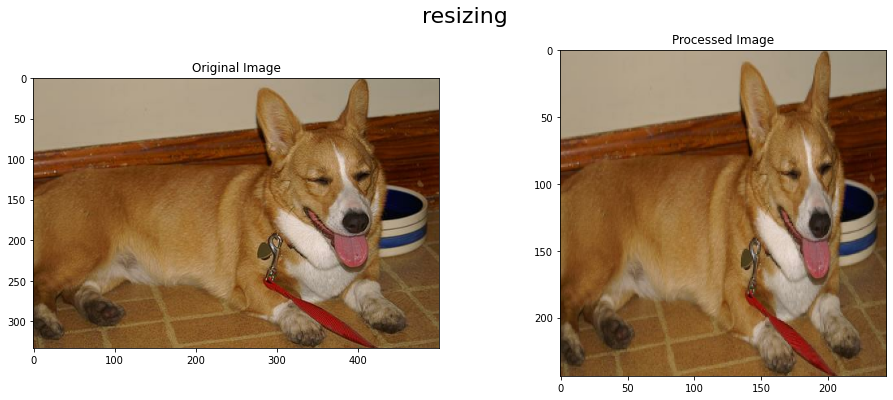

In [20]:
result = resize_and_rescale(image)
compare_images(image, result, "resizing")

Resizing is better with padding, in order to keep the dimension ratios

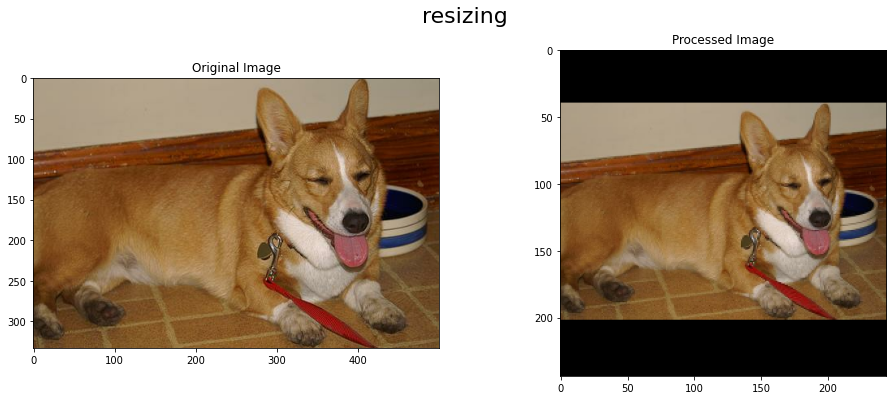

In [21]:

result = tf.image.resize_with_pad(image/255, IMG_SIZE, IMG_SIZE)
compare_images(image, result, "resizing")

In [22]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 0.94889235


### Equalization

Image equalization is interesting in order to have a consistent contrast in all the images.

A common way to achieve this is to use the 'histogram equalization' method:

<https://towardsdatascience.com/histogram-equalization-5d1013626e64>

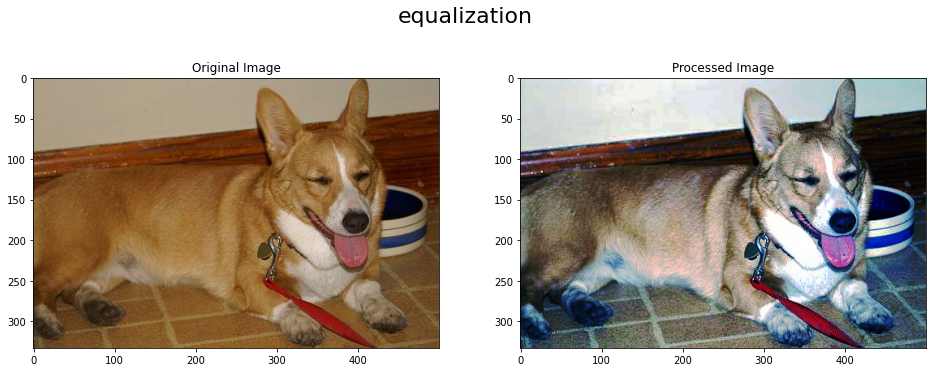

In [23]:
# image equalization
# https://towardsdatascience.com/histogram-equalization-5d1013626e64
import tensorflow_addons as tfa

result = tfa.image.equalize(image)
compare_images(image, result, "equalization")

### Standardization

Linearly scales each image to have mean 0 and variance 1

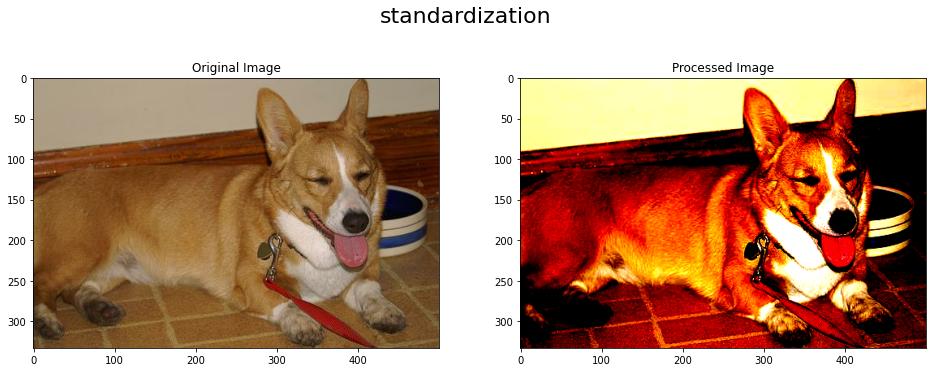

In [24]:

result = tf.image.per_image_standardization(image)
compare_images(image, result, "standardization")

### Image Filtering

We apply filtering in order to remove noise. Several methods exists (mean, gaussian), we choose here mean filtering

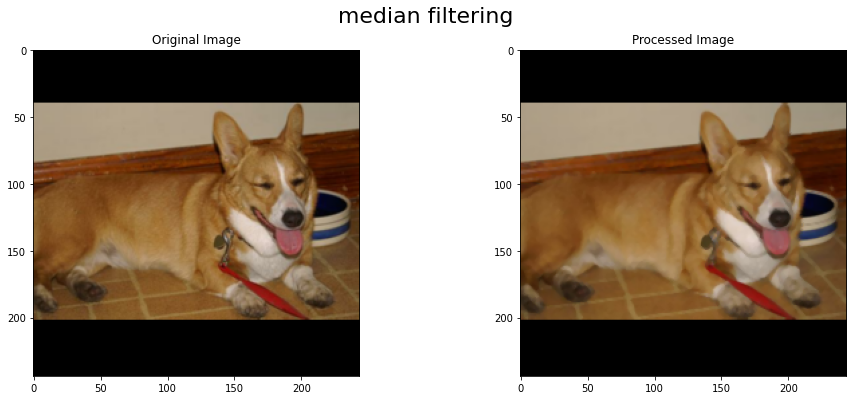

In [246]:

result = tfa.image.median_filter2d(image)
compare_images(image, result, "median filtering")


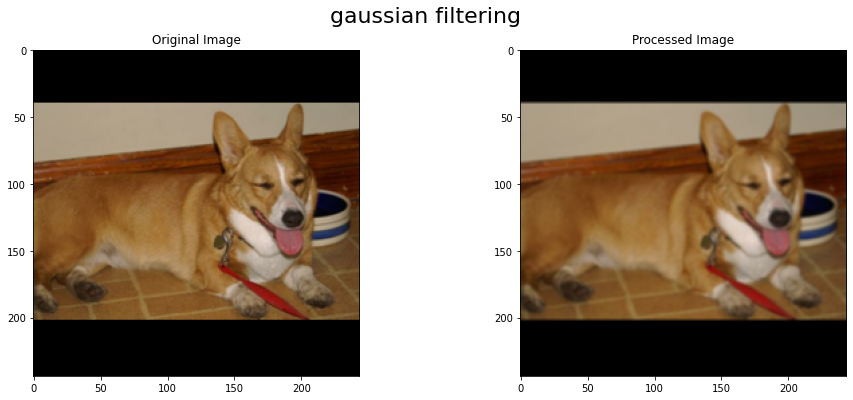

In [247]:
result = tfa.image.gaussian_filter2d(image)
compare_images(image, result, "gaussian filtering")

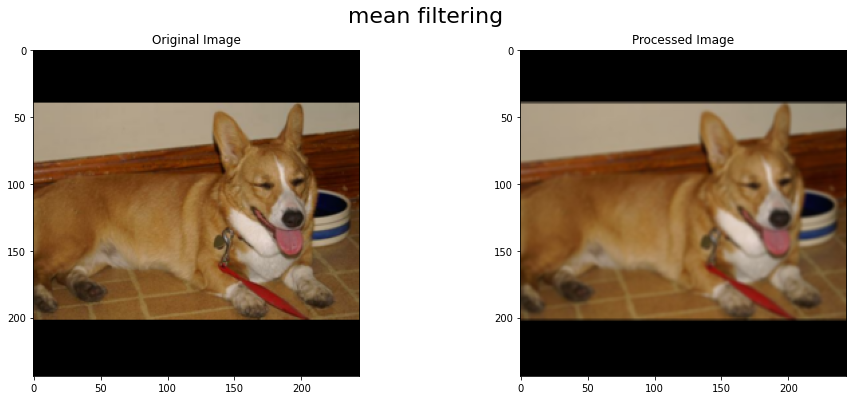

In [248]:
result = tfa.image.mean_filter2d(image)
compare_images(image, result, "mean filtering")

### Apply preprocessing to dataset

In [33]:
from tensorflow_addons.image import mean_filter2d

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds : tf.data.Dataset, shuffle=False, augment=False):
  # filter dataset
  ds = ds.map(lambda x,y: (mean_filter2d(x), y),
            num_parallel_calls=AUTOTUNE)
  
  # Resize and rescale
#   ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
  ds = ds.map(lambda x, y: (tf.image.resize_with_pad(x/255, IMG_SIZE, IMG_SIZE), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

#   TODO: ensure caching is required
  ds = ds.cache()

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)   

In [34]:
ds = prepare(ds_train)

In [45]:
ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [35]:
# show batches content
for image_batch, labels_batch in ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 244, 244, 3)
(32,)


2022-06-10 11:20:37.089579: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [20]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
#   resize_and_rescale,
#   data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

## Data Augmentation

Since our dataset contains only 20k samples, we need to find a way to add more samples.

This is done by using the existing sample and applying random transformations to it: crop, rotate, translate, flip, etc.

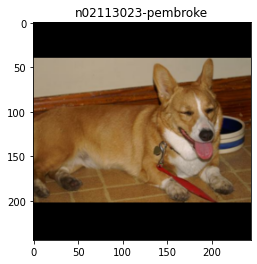

In [241]:
image, label = next(iter(ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

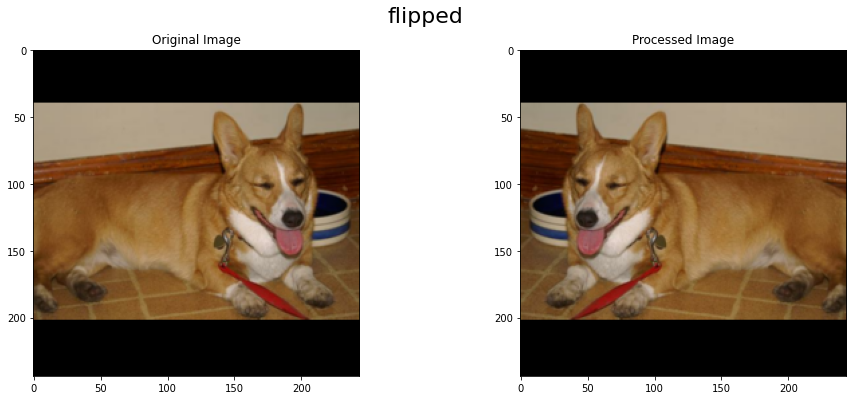

In [230]:
flipped = tf.image.flip_left_right(image)
compare_images(image, flipped, "flipped")

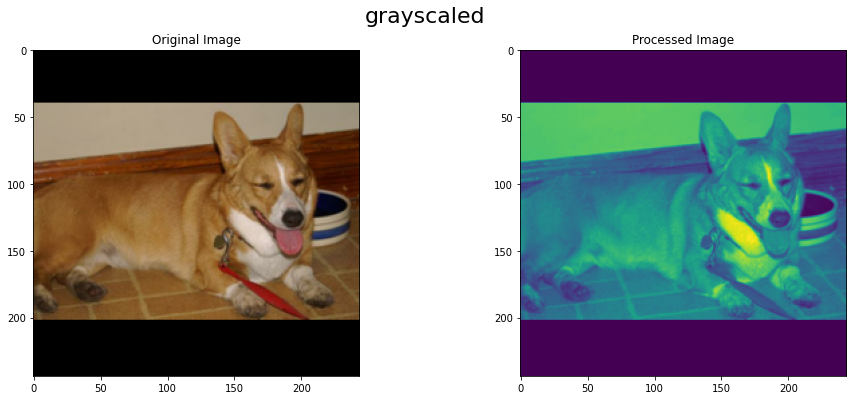

In [231]:
grayscaled = tf.image.rgb_to_grayscale(image)
compare_images(image, tf.squeeze(grayscaled), "grayscaled")

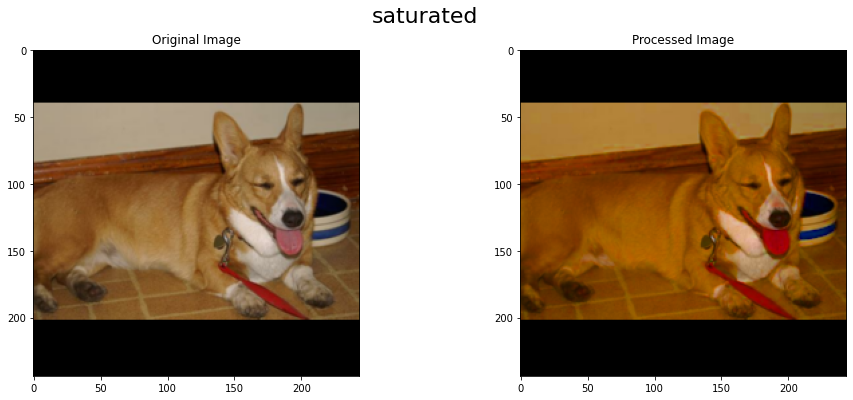

In [232]:
saturated = tf.image.adjust_saturation(image, 3)
compare_images(image, saturated, "saturated")

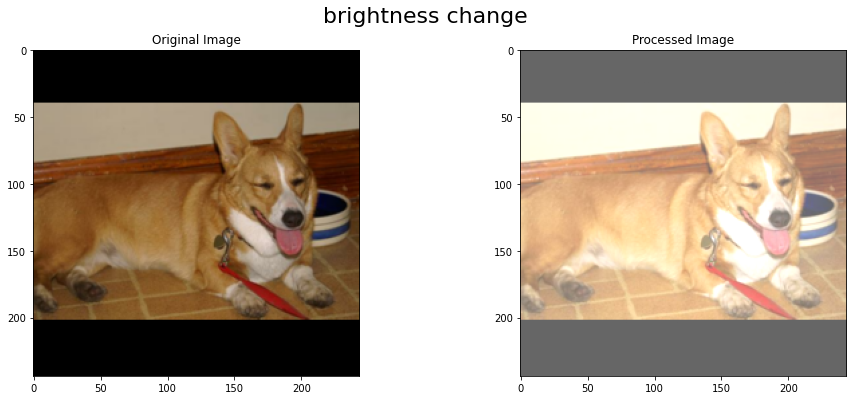

In [233]:
bright = tf.image.adjust_brightness(image, 0.4)
compare_images(image, bright, "brightness change")

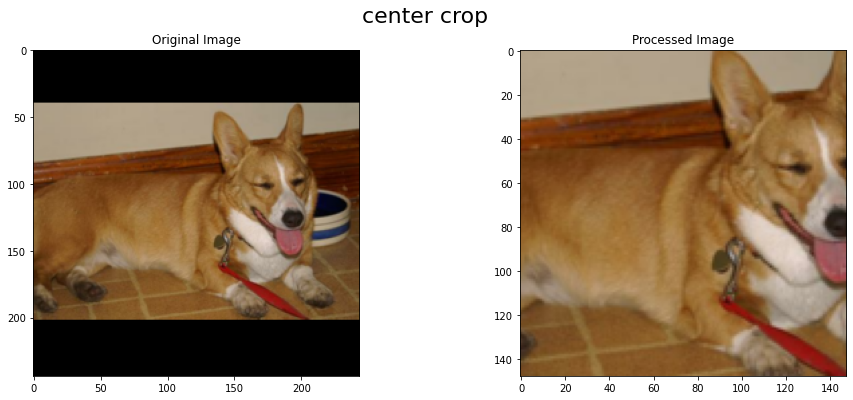

In [234]:
cropped = tf.image.central_crop(image, central_fraction=0.6)
compare_images(image, cropped, "center crop")

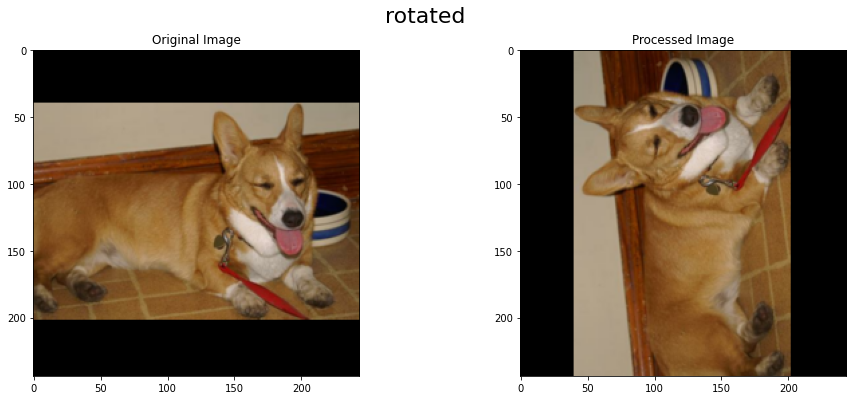

In [235]:
rotated = tf.image.rot90(image)
compare_images(image, rotated, "rotated")

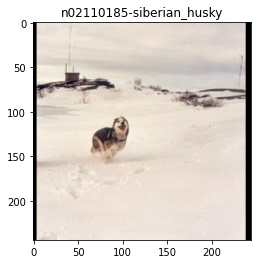

In [236]:
image, label = next(iter(ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [163]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

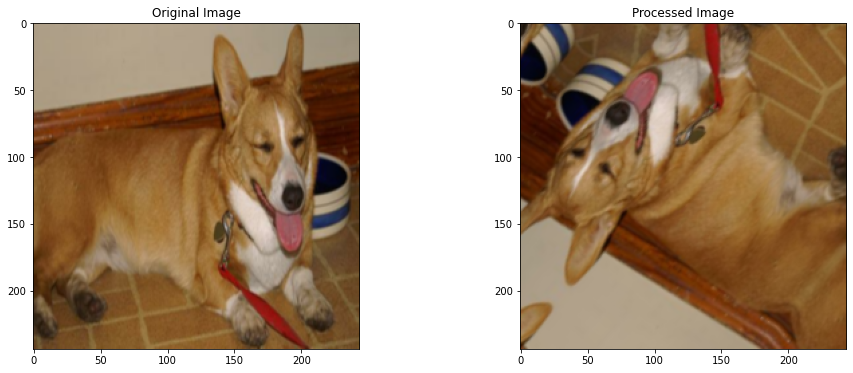

In [201]:
# TODO: why should we divide by 255 ? --> if not applying on the preprocessed dataset, otherwise not necessary

result = data_augmentation(image)
compare_images(image, result)

In [250]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<Figure size 720x720 with 0 Axes>

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

(-0.5, 243.5, 243.5, -0.5)

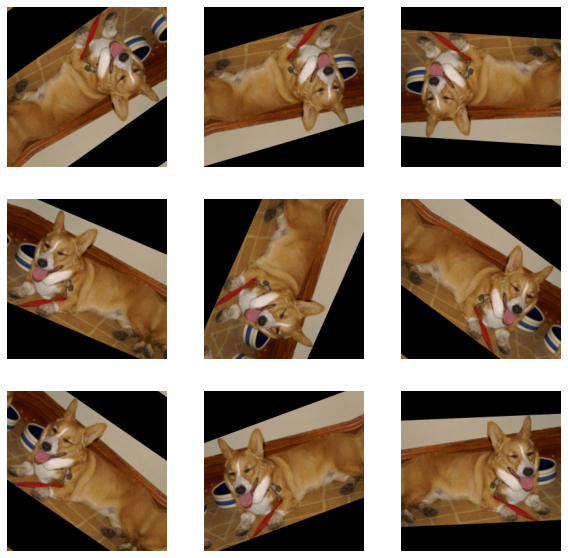

In [251]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
#   augmented_image = image
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Create Model

In [44]:
ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [37]:
# model with preprocessing layers

# tf.image.resize_with_pad(image/255, IMG_SIZE, IMG_SIZE)
# on applique de la data augmentation: rotation, cropping, contrast, flip

model = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE, crop_to_aspect_ratio=True), #faire un pad à la place
    layers.Rescaling(scale=1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)), #normalization
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    
])

In [28]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(244, 244, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [42]:
epochs=10
history = model.fit(
  ds_train,
  validation_data=ds_val,
  epochs=epochs
)

Epoch 1/10


ValueError: in user code:

    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(1,) and logits.shape=(59536, 3)


### Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [12]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

<Figure size 720x720 with 0 Axes>

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

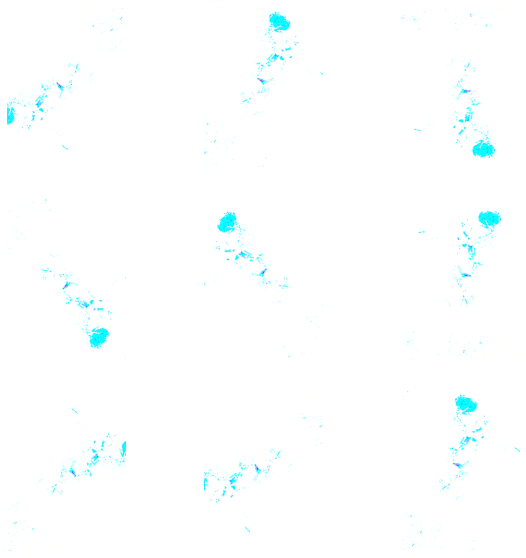

In [13]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Make the preprocessing part of the model

In [14]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

In [15]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(ds_train, shuffle=True, augment=True)
test_ds = prepare(ds_test)

## Train Model

In [17]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
epochs=5
history = model.fit(
  train_ds,
  epochs=epochs
)

Epoch 1/5
375/375 [==============================] - 156s 411ms/step - loss: 4.7920 - accuracy: 0.0074
Epoch 2/5
375/375 [==============================] - 155s 409ms/step - loss: 4.6601 - accuracy: 0.0150
Epoch 3/5
375/375 [==============================] - 155s 408ms/step - loss: 4.4939 - accuracy: 0.0247
Epoch 4/5
375/375 [==============================] - 157s 414ms/step - loss: 4.3900 - accuracy: 0.0331
Epoch 5/5
375/375 [==============================] - 160s 422ms/step - loss: 4.3063 - accuracy: 0.0476


In [20]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

269/269 [==============================] - 20s 75ms/step - loss: 4.2744 - accuracy: 0.0522
Accuracy 0.052214451134204865


### Custom Data augmentation

In [21]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [22]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

<Figure size 720x720 with 0 Axes>

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

(-0.5, 1387.5, 1878.5, -0.5)

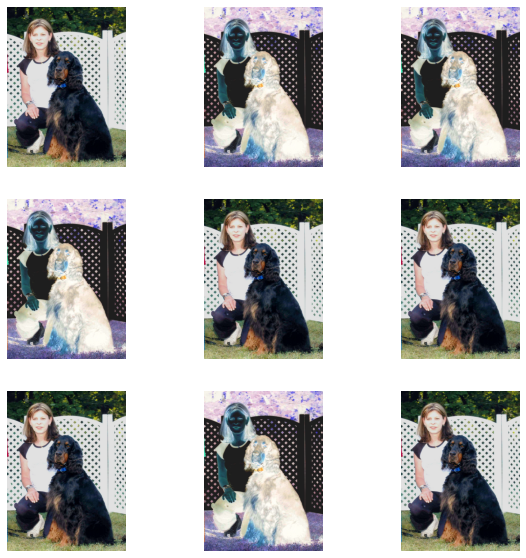

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [24]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

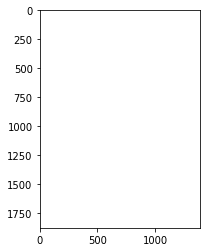

In [25]:
_ = plt.imshow(RandomInvert()(image)[0])

## APPENDIX

In [27]:

for images, labels in ds_train.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

labels = []

for x, y in ds_train:
    labels.append(y.numpy())
    # print(y.numpy())

np.max(labels)
np.min(labels)


119

0

(array([1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200.,
        1200.]),
 array([  0. ,  11.9,  23.8,  35.7,  47.6,  59.5,  71.4,  83.3,  95.2,
        107.1, 119. ]),
 <BarContainer object of 10 artists>)

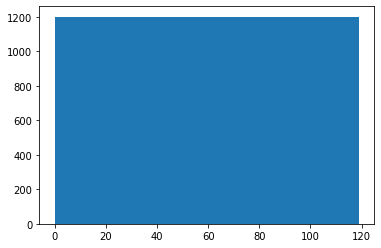

In [36]:
plt.hist(labels[:])

## Dummy model

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def resize_img(data, dimensions= (224, 224)):
    print(type(data))
    # return cv.resize(data['image'], dimensions, interpolation=cv.INTER_LINEAR)
    return tf.image.resize(data['image'], dimensions, method='nearest')

In [6]:
ds_train, ds_test, ds_info = load_dataset(as_supervised=False)

In [114]:
ds_train = ds_train.map(lambda data: resize_img(data))
ds_test = ds_test.map(lambda data: resize_img(data))

<class 'dict'>
<class 'dict'>


In [7]:
# ds_train = ds_train.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)




In [8]:
# ds_test = ds_test.map(
#     normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


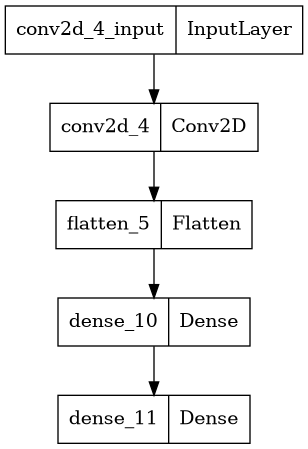

In [22]:

model = Sequential([
    Conv2D(filters=16,
            kernel_size=(3,3), 
            padding='same',
            use_bias=False,
            input_shape=(224,224,3)),
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(210)
])

plot_model(model)


In [24]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [25]:
train_data_gen = ImageDataGenerator(
    rescale=1./255
)

test_data_gen = ImageDataGenerator(
    rescale=1./255
)

In [26]:

model.fit(
    ds_train,
    epochs=6,
    validation_data=test_data_gen.flow(
        ds_test)
        
)


TypeError: float() argument must be a string or a number, not 'PrefetchDataset'

In [8]:
import matplotlib.pyplot as plt
from PIL import Image, ImageShow


for image, label in tfds.as_numpy(ds.take(3)):
  # print(type(image), type(label), label)
  # print(image)
  img = tf.keras.preprocessing.image.array_to_img(image)
  display(img)

ImportError: Could not import PIL.Image. The use of `array_to_img` requires PIL.

## Appendix

In [ ]:
# !pip install mlflow --quiet
# !pip install pyngrok --quiet
# !databricks configure --host https://community.cloud.databricks.com/vincentjuge@gmau


In [ ]:
# import mlflow
# mlflow.set_tracking_uri("databricks")
# mlflow.set_experiment("module_P6")

In [ ]:
# from pyngrok import conf, ngrok

# conf.get_default().auth_token = "29zP9P1odMu9Cc6uXkJiPLIHv5H_3EGpswe7jL1Ey6HZwyFs7"

# Open a HTTP tunnel on the default port 80
# <NgrokTunnel: "http://<public_sub>.ngrok.io" -> "http://localhost:80">

# http_tunnel = ngrok.connect()

# Open a SSH tunnel
# <NgrokTunnel: "tcp://0.tcp.ngrok.io:12345" -> "localhost:22">

# ssh_tunnel = ngrok.connect(22, "tcp")